# Importing Libraries

In [87]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Loading and Transformation
Dataset created by using a script to run 2000 minmax vs minmax game and storing the outputs into a file. 
We parse the data using the code below and add a column called discounted score. The discounted score represents the number of reward points given to each board. The discount factor$(\gamma)$ is used as
$r_f=final\:score*\gamma^0$<br>
$r_{f-1}=final\:score*\gamma^1$

In [127]:


def board_to_matrix(board_str, expected_row_length=15):
    board_str = board_str.strip().split('\n')
    board_matrix = []
    for row in board_str:
        if len(row) == expected_row_length:
            board_row = [0 if cell == '.' else (2 if cell == 'x' else 1) for cell in row]
            board_matrix.append(board_row)
    return np.array(board_matrix)

data = []
gamma = 0.9
for game_number in range(1, 2001):
    filename = f"dataset/game{game_number}.txt"
    if os.path.exists(filename):
        with open(filename, 'r') as file:
            content = file.read()


        turns = content.split('Turn')
        outcome = None
        final_score = None  
        board_str = ''
        game_data = []  

        for turn in turns:
            if 'Final score:' in turn:
                # Determine the game outcome and final score from the final score line
                score_str = turn.split('Final score:')[1].split('\n')[0].strip()
                final_score = float(score_str)  # Convert the score to a float
                outcome = 'Max' if final_score > 0 else ('Min' if final_score < 0 else 'Tie')

            if turn.strip() and 'Minimax took' in turn:
                move_number = int(turn.split(':')[0].strip())
                board_str = turn.split('seconds')[1].split('Turn')[0]
                board_matrix = board_to_matrix(board_str)
                player = 'Max' if move_number % 2 == 0 else 'Min'
                game_data.append({'Game': game_number, 'Move': move_number, 'Player': player, 'Board': board_matrix})

        # Assign the final outcome and final score to each move of the game
        for move in game_data:
            move['Outcome'] = outcome
            move['Final Score'] = final_score
            data.append(move)
        total_moves = len(game_data)  # Get the total number of moves in the game

        # Apply the discount factor to the final score for each move
        for i, move in enumerate(game_data):
            discount_exponent = total_moves - i - 1
            discounted_score = final_score * (gamma ** discount_exponent)
            move['Discounted Score'] = discounted_score
            data.append(move)


# Create the dataframe from the collected data
df = pd.DataFrame(data)

# Display the dataframe
df


,Game,Move,Player,Board,Outcome,Final Score,Discounted Score
0,1,0,Max,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Min,-122.0,-0.002362
1,1,1,Min,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Min,-122.0,-0.002625
2,1,2,Max,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Min,-122.0,-0.002916
3,1,3,Min,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Min,-122.0,-0.003240
4,1,4,Max,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Min,-122.0,-0.003601
...,...,...,...,...,...,...,...
401107,2000,38,Max,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Max,183.0,120.066300
401108,2000,39,Min,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Max,183.0,133.407000
401109,2000,40,Max,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Max,183.0,148.230000
401110,2000,41,Min,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",Max,183.0,164.700000


# Data Cleaning
We only choose the data where the in player is winning

In [129]:
min_df = df[(df['Outcome']=='Min')&(df['Player'] == 'Min')]
min_df = min_df.drop_duplicates(subset=['Game', 'Move'])
min_df

# Visualizing the Rewards

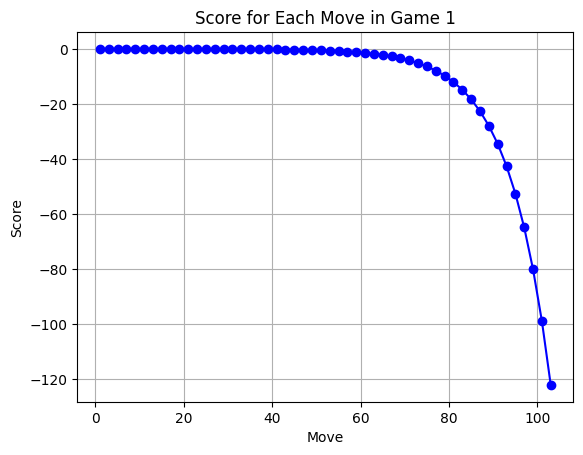

In [131]:
game_1_df = min_df[min_df['Game'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(game_1_df['Move'], game_1_df['Discounted Score'], marker='o', linestyle='-', color='b')
plt.title('Score for Each Move in Game 1')
plt.xlabel('Move')
plt.ylabel('Score')
plt.grid(True)
plt.show()

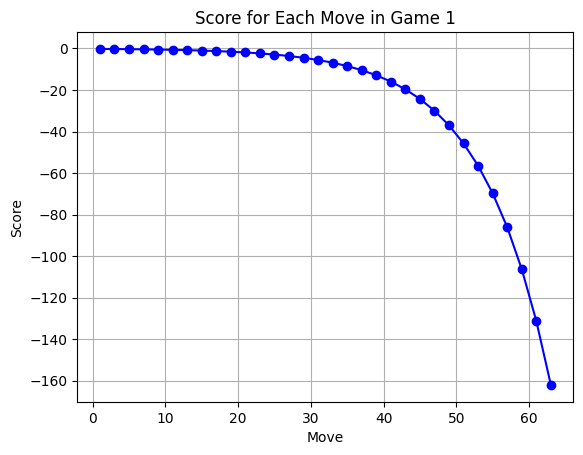

In [132]:
game_df = min_df[min_df['Game'] == 3]
plt.figure(figsize=(10, 6))
plt.plot(game_df['Move'], game_df['Discounted Score'], marker='o', linestyle='-', color='b')
plt.title('Score for Each Move in Game 3')
plt.xlabel('Move')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# Creating Pytorch Dataset
80-20 Train test split and a batchsize of 32 for training the model.

In [133]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

class GomokuDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        board = torch.tensor(self.dataframe.iloc[idx]['Board']).float()
        board = board.unsqueeze(0) / 2  # Add a channel dimension and normalize
        score = torch.tensor(self.dataframe.iloc[idx]['Discounted Score']).float()
        return board, score

train_df, val_df = train_test_split(min_df, test_size=0.2)

train_dataset = GomokuDataset(train_df)
val_dataset = GomokuDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Pytorch CNN Model
We implimented a CNN model in pytorch. The model had 3 convolution layers and 3 fully connected layers with a dropout of 0.3 between the first two fully connected layers. We kept the filter size as 5 so that the model can see bigger patterns and learn better filters.  

In [135]:
class GomokuCNN(nn.Module):
    def __init__(self, dropout_prob=0.3):  
        super(GomokuCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 15 * 15, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

        # Dropout layer only for fully connected layers
        self.drop_fc = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)  
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x.squeeze()

In [141]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses_epoch = []
    val_losses_epoch = []
    train_losses_updates = []
    val_losses_updates = []

    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0

        # Training phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * inputs.size(0)
            train_losses_updates.append(loss.item())

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_losses_epoch.append(epoch_loss_train)

        # Validation phase
        model.eval()
        running_loss_val = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * inputs.size(0)
                val_losses_updates.append(loss.item())

        epoch_loss_val = running_loss_val / len(val_loader.dataset)
        val_losses_epoch.append(epoch_loss_val)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss_train:.4f}, Validation Loss: {epoch_loss_val:.4f}')

    return train_losses_epoch, val_losses_epoch, train_losses_updates, val_losses_updates



    
model = GomokuCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses_epoch, val_losses_epoch, train_losses_updates, val_losses_updates = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=20
)

Epoch 1/20, Training Loss: 1046.8909, Validation Loss: 995.8442
Epoch 2/20, Training Loss: 996.2111, Validation Loss: 955.7964
Epoch 3/20, Training Loss: 921.1519, Validation Loss: 870.0064
Epoch 4/20, Training Loss: 721.9376, Validation Loss: 601.5044
Epoch 5/20, Training Loss: 414.0534, Validation Loss: 467.3108
Epoch 6/20, Training Loss: 230.2449, Validation Loss: 313.9155
Epoch 7/20, Training Loss: 152.0094, Validation Loss: 240.1510
Epoch 8/20, Training Loss: 113.6226, Validation Loss: 198.3782
Epoch 9/20, Training Loss: 96.9291, Validation Loss: 207.1889
Epoch 10/20, Training Loss: 88.5228, Validation Loss: 198.0924
Epoch 11/20, Training Loss: 80.0680, Validation Loss: 181.1875
Epoch 12/20, Training Loss: 78.4195, Validation Loss: 166.7968
Epoch 13/20, Training Loss: 67.4018, Validation Loss: 201.4774
Epoch 14/20, Training Loss: 62.1133, Validation Loss: 145.6131
Epoch 15/20, Training Loss: 62.6003, Validation Loss: 169.1307
Epoch 16/20, Training Loss: 55.5942, Validation Loss: 1

In [142]:
torch.save(model.state_dict(), 'gomoku_cnn_model_final.pth')

# Model Results

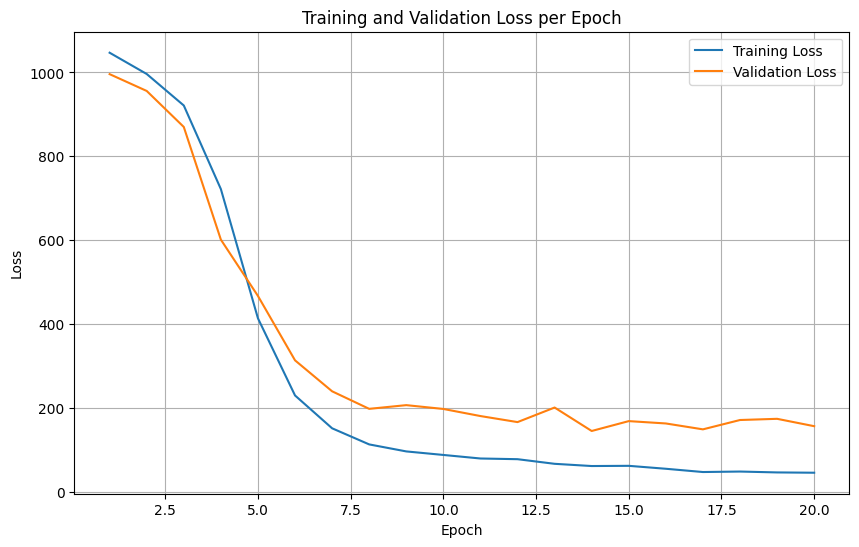

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses_epoch, label='Training Loss')
plt.plot(range(1, 21), val_losses_epoch, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


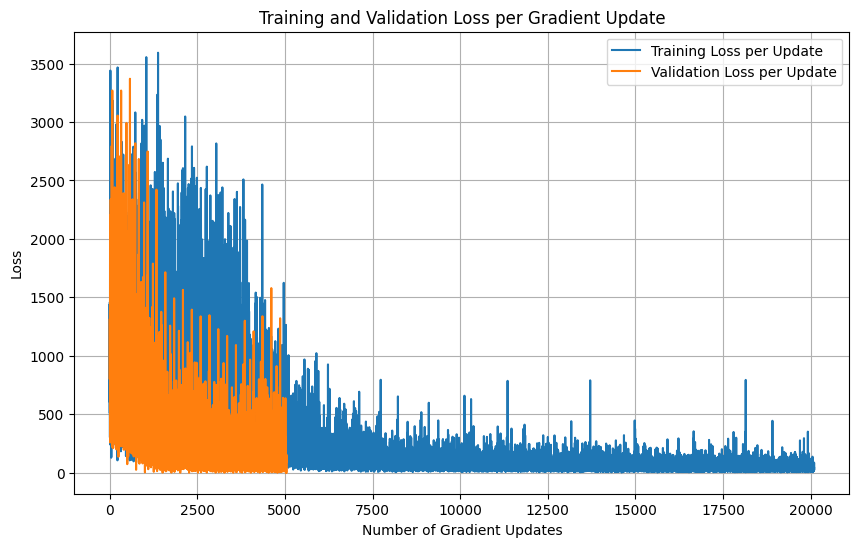

In [144]:
# Plot for Loss vs Number of Gradient Updates
plt.figure(figsize=(10, 6))
plt.plot(train_losses_updates, label='Training Loss per Update')
plt.plot(val_losses_updates, label='Validation Loss per Update')
plt.title('Training and Validation Loss per Gradient Update')
plt.xlabel('Number of Gradient Updates')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

In [15]:
def prepare_board(board):
    """ Prepare the Gomoku board for prediction. """
    tensor_board = torch.tensor(board).float()
    tensor_board = tensor_board.unsqueeze(0) / 2  # Add only one channel dimension and normalize
    return tensor_board

In [16]:
c=df[(df['Game'] == 5) & (df['Move'] == 32)]["Board"]
prepared_board = prepare_board(list(c))
model.eval()
with torch.no_grad():
    predicted_score = model(prepared_board)
    print(f"Predicted Heuristic Score: {predicted_score.item()}")

Predicted Heuristic Score: -146.4103546142578


/var/folders/2h/9_s3l0m92f333yjdcwr8869m0000gn/T/ipykernel_17062/1633081473.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  tensor_board = torch.tensor(board).float()
